    K  Quality_pred  Quality_truth      nDCG
0   5      0.021369       0.379917  0.778775
1  10      0.028366       0.524017  0.711242
2  20      0.043306       0.701210  0.651250
3  50      0.106657       0.878593  0.546122


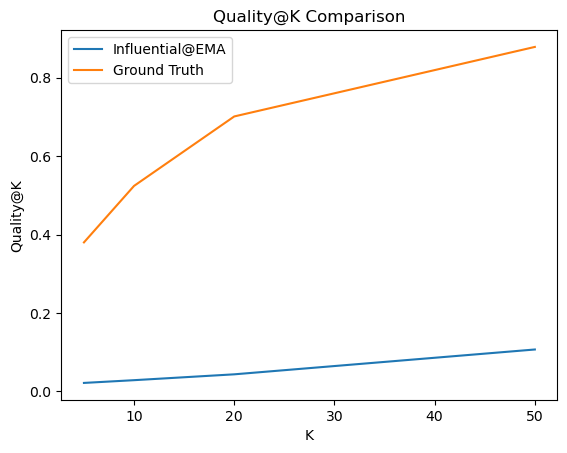

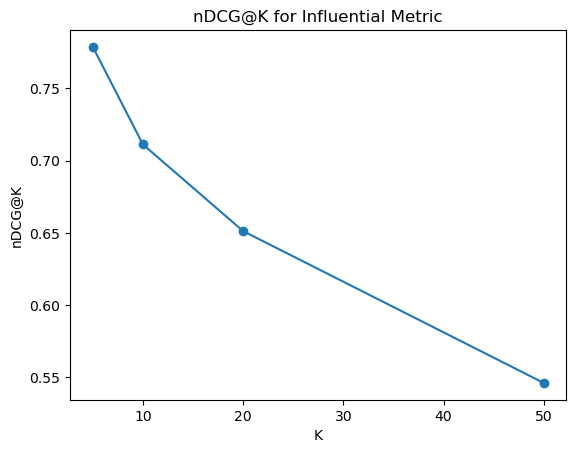

In [33]:
# Group 3: Influential Superspreader Detection
# Jupyter Notebook for implementing and evaluating the Influential metric-based recommender

# --- 1. Imports and Settings ---
import pandas as pd
import numpy as np
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt

# Settings
DATA_PATH = './COVID19_sample.csv'  # adjust if needed
NEWSGUARD_THRESHOLD = 39  # low-credibility threshold
DELTA_DAYS = 14          # time slot length
ALPHA = 0.5              # EMA smoothing factor

# --- 2. Load and Preprocess Data ---
def load_and_preprocess(path):
    """
    Load the re-posts dataset, filter for low-credibility content,
    exclude self-reposts, and parse timestamps.
    """
    df = pd.read_csv(path, parse_dates=['created_at'])
    df = df.rename(columns={
        'created_at': 'timestamp',
        'credibility_score': 'newsguard_score',
        'retweeted_user_id': 'original_author_id'
    })
    df = df[df['newsguard_score'] <= NEWSGUARD_THRESHOLD]
    df = df[df['user_id'] != df['original_author_id']]
    return df

df = load_and_preprocess(DATA_PATH)

# --- 3. Compute Influential Metric per User per Time Slot ---
def compute_influential_by_slot(df, start_date, end_date, delta):
    """
    Partition the data into time slots of length `delta` days and compute
    total re-posts per user in each slot.
    """
    slots = {}
    current_start = start_date
    slot_idx = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=delta)
        mask = (df['timestamp'] >= current_start) & (df['timestamp'] < current_end)
        sub = df[mask]
        counts = sub.groupby('original_author_id').size()
        slots[slot_idx] = counts
        slot_idx += 1
        current_start = current_end
    return slots

min_date, max_date = df['timestamp'].min(), df['timestamp'].max()
slots = compute_influential_by_slot(df, min_date, max_date, DELTA_DAYS)

# --- 4. Exponential Moving Average of Influential Scores ---
def ema_scores(slots, alpha):
    """
    Apply EMA over sequence of slot Series to smooth scores.
    """
    ema = pd.Series(dtype=float)
    for t in sorted(slots.keys()):
        curr = slots[t].reindex(ema.index.union(slots[t].index), fill_value=0)
        ema = alpha * ema + (1 - alpha) * curr
    return ema

influential_ema = ema_scores(slots, ALPHA)
predicted_ranking = influential_ema.sort_values(ascending=False)

# --- 5. Build Low-Credibility Re-Share Network ---
G = nx.DiGraph()
for _, row in df.iterrows():
    u, v = row['original_author_id'], row['user_id']
    G.add_edge(u, v, weight=G[u][v]['weight'] + 1 if G.has_edge(u, v) else 1)

total_weight = sum(d['weight'] for _, _, d in G.edges(data=True))

# --- 6. Network Dismantling Evaluation ---
def network_dismantling(G, ranking, ks):
    qualities = {}
    for K in ks:
        removed = set(ranking.index[:K])
        prevented = sum(
            data['weight'] for u, v, data in G.edges(data=True)
            if u in removed or v in removed
        )
        qualities[K] = prevented / total_weight
    return qualities

ground_truth = df.groupby('original_author_id').size().sort_values(ascending=False)
Ks = [5, 10, 20, 50]
quality_pred = network_dismantling(G, predicted_ranking, Ks)
quality_truth = network_dismantling(G, ground_truth, Ks)

# --- 7. Compute nDCG@K ---
from sklearn.metrics import ndcg_score

def compute_ndcg(pred_ranking, truth_ranking, K):
    users = list(truth_ranking.index[:K])
    y_true = np.array([truth_ranking.get(u, 0) for u in users], dtype=float)
    y_score = np.array([pred_ranking.get(u, 0) for u in users], dtype=float)
    # Replace any NaNs
    y_true = np.nan_to_num(y_true)
    y_score = np.nan_to_num(y_score)
    return ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=K)

ndcg_pred = {K: compute_ndcg(predicted_ranking, ground_truth, K) for K in Ks}

# --- 8. Results & Visualization ---
results = pd.DataFrame({
    'K': Ks,
    'Quality_pred': [quality_pred[K] for K in Ks],
    'Quality_truth': [quality_truth[K] for K in Ks],
    'nDCG': [ndcg_pred[K] for K in Ks]
})
print(results)

plt.figure()
plt.plot(results['K'], results['Quality_pred'], label='Influential@EMA')
plt.plot(results['K'], results['Quality_truth'], label='Ground Truth')
plt.xlabel('K'); plt.ylabel('Quality@K')
plt.title('Quality@K Comparison'); plt.legend(); plt.show()

plt.figure()
plt.plot(results['K'], results['nDCG'], marker='o')
plt.xlabel('K'); plt.ylabel('nDCG@K')
plt.title('nDCG@K for Influential Metric'); plt.show()
